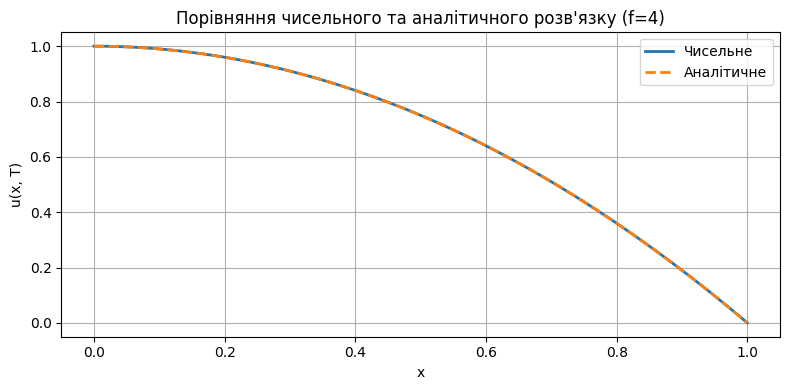

In [7]:
#ПРИКЛАД 1. ОДНОВИМІРНЕ РІВНЯННЯ
import numpy as np
import matplotlib.pyplot as plt

def analytical_solution(x, t):
    return t**2 - x**2

def f_constant(x, t):
    return 4.0

def wave_solver_analytical(Nx, Nt, L=1.0, T_max=1.0, c=1.0):
    dx = L / (Nx - 1)
    dt = T_max / Nt
    x = np.linspace(0, L, Nx)

    if c * dt / dx > 1:
        raise ValueError("CFL > 1, схема нестійка")

    u = np.zeros(Nx)
    u_old = np.zeros(Nx)
    u_new = np.zeros(Nx)

    # Початкові умови
    u[:] = analytical_solution(x, 0)
    u_old[:] = analytical_solution(x, -dt)

    for n in range(1, Nt + 1):
        t = n * dt
        for i in range(1, Nx - 1):
            u_new[i] = (2 * u[i] - u_old[i] +
                        (c * dt / dx)**2 * (u[i + 1] - 2 * u[i] + u[i - 1]) +
                        dt**2 * f_constant(x[i], t))

        # граничні умови Діріхле(з точного розв’язку)
        u_new[0] = analytical_solution(x[0], t)
        u_new[-1] = analytical_solution(x[-1], t)

        u_old[:], u[:] = u[:], u_new[:]

    return x, u, analytical_solution(x, T_max)

Nx = 100
Nt = 1000
L = 1.0
T_max = 1.0
c = 1.0

x, u_num, u_exact = wave_solver_analytical(Nx, Nt, L=L, T_max=T_max, c=c)

plt.figure(figsize=(8, 4))
plt.plot(x, u_num, label='Чисельне', lw=2)
plt.plot(x, u_exact, '--', label='Аналітичне', lw=2)
plt.title("Порівняння чисельного та аналітичного розв'язку (f=4)")
plt.xlabel("x")
plt.ylabel("u(x, T)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

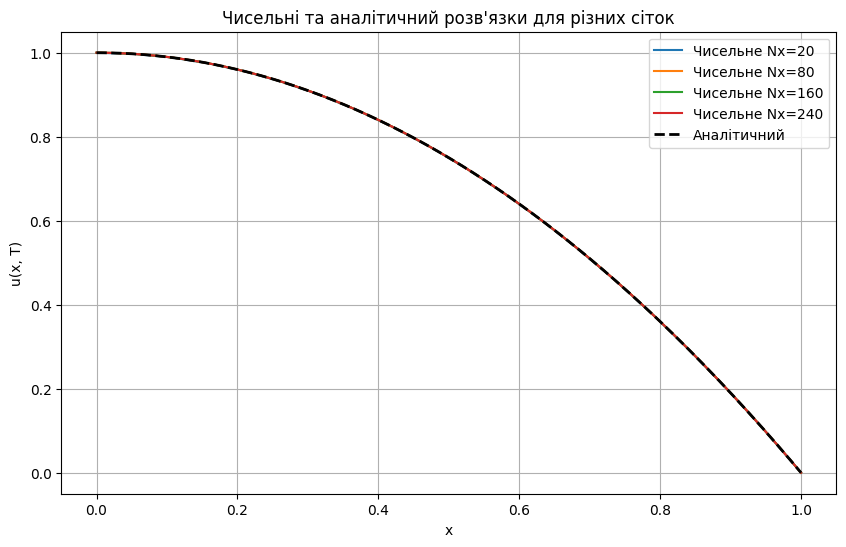

In [2]:
#Чисельні та аналітичні розв'язки для різних сіток
def analytical_solution(x, t):
    return t**2 - x**2

def f_source(x, t):
    return 4.0

def wave_solver(Nx, Nt, L=1.0, T_max=1.0, c=1.0):
    dx = L / (Nx - 1)
    dt = T_max / Nt
    x = np.linspace(0, L, Nx)

    CFL = c * dt / dx
    if CFL > 1.0:
        raise ValueError(f"Схема нестійка: CFL = {CFL:.2f} > 1")

    u = np.zeros(Nx)
    u_new = np.zeros(Nx)
    u_old = np.zeros(Nx)

    t0 = 0.0
    u[:] = analytical_solution(x, t0)
    u_old[:] = analytical_solution(x, t0 - dt)

    for n in range(1, Nt + 1):
        t = n * dt
        for i in range(1, Nx - 1):
            u_new[i] = (2 * u[i] - u_old[i] +
                        (c * dt / dx)**2 * (u[i + 1] - 2 * u[i] + u[i - 1]) +
                        dt**2 * f_source(x[i], t))

        u_new[0] = analytical_solution(x[0], t)
        u_new[-1] = analytical_solution(x[-1], t)

        u_old[:], u[:] = u[:], u_new[:]

    return x, u, analytical_solution(x, T_max)

Nx_values = [20, 80, 160, 240]
Nt = 1000

plt.figure(figsize=(10, 6))
for Nx in Nx_values:
    x, u_num, u_true = wave_solver(Nx, Nt)
    plt.plot(x, u_num, label=f'Чисельне Nx={Nx}')

plt.plot(x, u_true, 'k--', linewidth=2, label='Аналітичний')
plt.title("Чисельні та аналітичний розв'язки для різних сіток")
plt.xlabel("x")
plt.ylabel("u(x, T)")
plt.legend()
plt.grid(True)
plt.show()

dt = 0.005005 с, Nt = 1998, CFL = 0.50


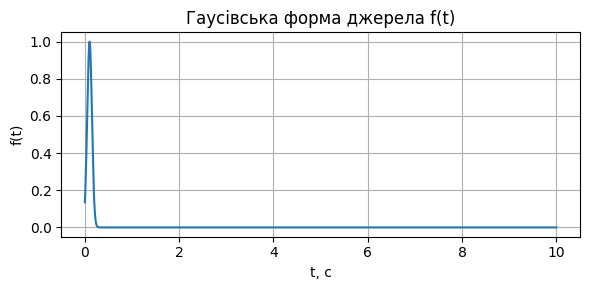

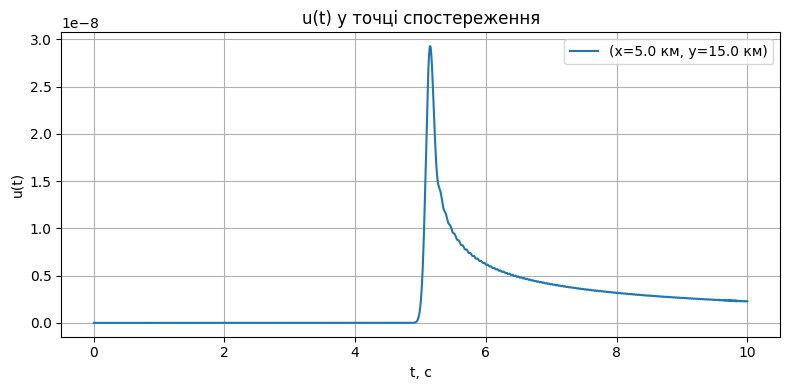

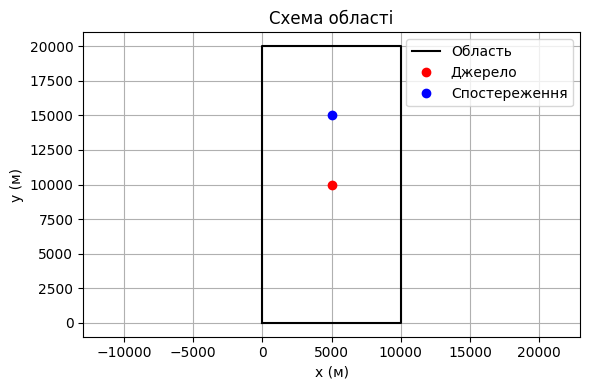

In [3]:
#ПРИКЛАД 2. ОДНОРІДНА ОБЛАСТЬ

import numpy as np
import matplotlib.pyplot as plt
from numba import njit

def source_time_function(t, t0=0.1, sigma=0.05):
    return np.exp(-((t - t0)**2) / (2 * sigma**2))

def f_source_2d(x, y, t, x_s, y_s, dx, dy):
    source = np.zeros((x.size, y.size))
    i_s = np.argmin(np.abs(x - x_s))
    j_s = np.argmin(np.abs(y - y_s))
    source[i_s, j_s] = 1.0 / (dx * dy)
    return source * source_time_function(t)

@njit
def update_wave(u, u_old, c, rhs, dx, dy, dt):
    Nx, Ny = u.shape
    u_new = np.zeros_like(u)
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            lap = ((u[i+1, j] - 2*u[i, j] + u[i-1, j]) / dx**2 +
                   (u[i, j+1] - 2*u[i, j] + u[i, j-1]) / dy**2)
            u_new[i, j] = 2 * u[i, j] - u_old[i, j] + dt**2 * (c[i, j]**2 * lap + rhs[i, j])
    return u_new

def wave_solver_2d(Nx=100, Ny=200, Lx=10000.0, Ly=20000.0, T_max=2.0, c_val=1000.0,
                   x_s=None, y_s=None, x_obs_list=None, y_obs_list=None, CFL_target=0.5,
                   use_source=True):

    dx = Lx / (Nx - 1)
    dy = Ly / (Ny - 1)
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)

    c = np.full((Nx, Ny), c_val)

    dt = CFL_target * min(dx, dy) / np.max(c)
    Nt = int(T_max / dt)
    dt = T_max / Nt

    print(f"dt = {dt:.6f} с, Nt = {Nt}, CFL = {np.max(c) * dt / min(dx, dy):.2f}")

    u = np.zeros((Nx, Ny))
    u_old = np.zeros((Nx, Ny))

    if x_s is None: x_s = Lx / 2
    if y_s is None: y_s = Ly / 2

    if x_obs_list is None: x_obs_list = [x_s]
    if y_obs_list is None: y_obs_list = [y_s + 5000.0]  # 5 км вище

    obs_indices = [(np.argmin(np.abs(x - xo)), np.argmin(np.abs(y - yo))) for xo, yo in zip(x_obs_list, y_obs_list)]
    u_records = [[] for _ in obs_indices]

    for n in range(1, Nt + 1):
        t = n * dt
        rhs = f_source_2d(x, y, t, x_s, y_s, dx, dy) if use_source else np.zeros((Nx, Ny))
        u_new = update_wave(u, u_old, c, rhs, dx, dy, dt)
        u_new[0, :] = u_new[-1, :] = 0
        u_new[:, 0] = u_new[:, -1] = 0
        u_old[:], u[:] = u[:], u_new[:]
        for k, (i_obs, j_obs) in enumerate(obs_indices):
            u_records[k].append(u[i_obs, j_obs])

    return x, y, u, [np.array(r) for r in u_records], dt, c, x_s, y_s, x_obs_list, y_obs_list

Nx, Ny = 1000, 2000
Lx, Ly = 10000.0, 20000.0
T_max = 10.0
x_s, y_s = 5000.0, 10000.0  # джерело в центрі
x_obs = [5000.0]
y_obs = [15000.0]  # точка спостереження на 5 км вище

x, y, u_final, u_records, dt, c, x_s, y_s, x_obs_list, y_obs_list = wave_solver_2d(
    Nx=Nx, Ny=Ny, Lx=Lx, Ly=Ly, T_max=T_max,
    c_val=1000.0,
    x_s=x_s, y_s=y_s,
    x_obs_list=x_obs, y_obs_list=y_obs,
    use_source=True
)

t_arr = np.linspace(0, T_max, 1000)
f_arr = source_time_function(t_arr)
plt.figure(figsize=(6, 3))
plt.plot(t_arr, f_arr)
plt.title("Гаусівська форма джерела f(t)")
plt.xlabel("t, с")
plt.ylabel("f(t)")
plt.grid(True)
plt.tight_layout()
plt.show()

time = np.linspace(dt, T_max, len(u_records[0]))
plt.figure(figsize=(8, 4))
plt.plot(time, u_records[0], label=f'(x={x_obs[0]/1000:.1f} км, y={y_obs[0]/1000:.1f} км)')
plt.title("u(t) у точці спостереження")
plt.xlabel("t, с")
plt.ylabel("u(t)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
plt.plot([0, Lx, Lx, 0, 0], [0, 0, Ly, Ly, 0], 'k-', label='Область')
plt.plot(x_s, y_s, 'ro', label='Джерело')
for xi, yi in zip(x_obs_list, y_obs_list):
    plt.plot(xi, yi, 'bo', label='Спостереження')
plt.title("Схема області")
plt.xlabel("x (м)")
plt.ylabel("y (м)")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()

dt = 0.012516 с, Nt = 799, CFL = 0.50


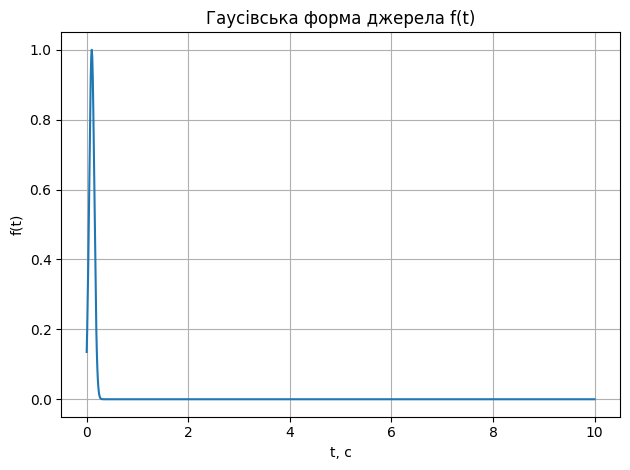

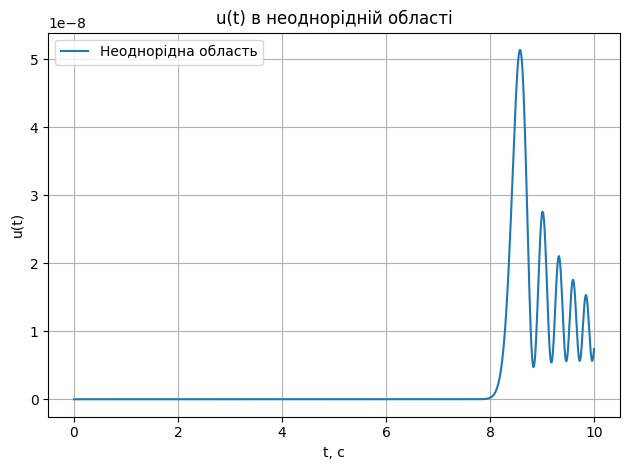

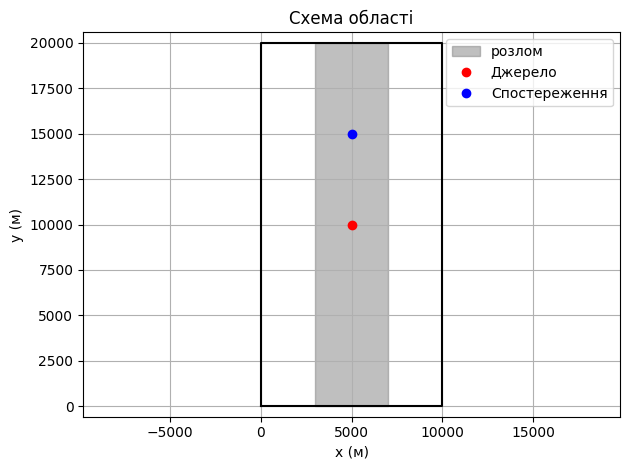

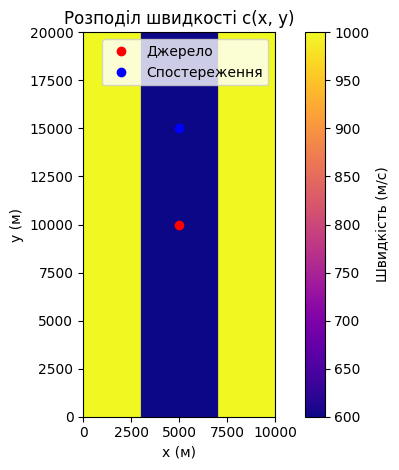

In [4]:
#ПРИКЛАД 3. НЕОДНОРІДНА ОБЛАСТЬ

import numpy as np
import matplotlib.pyplot as plt
from numba import njit

def source_time_function(t, t0=0.1, sigma=0.05):
    return np.exp(-((t - t0)**2) / (2 * sigma**2))

def f_source_2d(x, y, t, x_s, y_s, dx, dy):
    source = np.zeros((x.size, y.size))
    i_s = np.argmin(np.abs(x - x_s))
    j_s = np.argmin(np.abs(y - y_s))
    source[i_s, j_s] = 1.0 / (dx * dy)
    return source * source_time_function(t)

@njit
def update_wave(u, u_old, c, rhs, dx, dy, dt):
    Nx, Ny = u.shape
    u_new = np.zeros_like(u)
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            lap = ((u[i+1, j] - 2*u[i, j] + u[i-1, j]) / dx**2 +
                   (u[i, j+1] - 2*u[i, j] + u[i, j-1]) / dy**2)
            u_new[i, j] = 2 * u[i, j] - u_old[i, j] + dt**2 * (c[i, j]**2 * lap + rhs[i, j])
    return u_new

def wave_solver_2d(Nx=100, Ny=200, Lx=10000.0, Ly=20000.0, T_max=2.0,
                   c_matrix=None, x_s=None, y_s=None, x_obs_list=None, y_obs_list=None, CFL_target=0.5,
                   use_source=True):

    dx = Lx / (Nx - 1)
    dy = Ly / (Ny - 1)
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)

    if c_matrix is None:
        c = np.full((Nx, Ny), 1000.0)
    else:
        c = c_matrix

    dt = CFL_target * min(dx, dy) / np.max(c)
    Nt = int(T_max / dt)
    dt = T_max / Nt

    print(f"dt = {dt:.6f} с, Nt = {Nt}, CFL = {np.max(c) * dt / min(dx, dy):.2f}")

    u = np.zeros((Nx, Ny))
    u_old = np.zeros((Nx, Ny))

    if x_s is None: x_s = Lx / 2
    if y_s is None: y_s = Ly / 2

    if x_obs_list is None: x_obs_list = [x_s]
    if y_obs_list is None: y_obs_list = [y_s + 5000.0]

    obs_indices = [(np.argmin(np.abs(x - xo)), np.argmin(np.abs(y - yo))) for xo, yo in zip(x_obs_list, y_obs_list)]
    u_records = [[] for _ in obs_indices]

    for n in range(1, Nt + 1):
        t = n * dt
        rhs = f_source_2d(x, y, t, x_s, y_s, dx, dy) if use_source else np.zeros((Nx, Ny))
        u_new = update_wave(u, u_old, c, rhs, dx, dy, dt)
        u_new[0, :] = u_new[-1, :] = 0
        u_new[:, 0] = u_new[:, -1] = 0
        u_old[:], u[:] = u[:], u_new[:]
        for k, (i_obs, j_obs) in enumerate(obs_indices):
            u_records[k].append(u[i_obs, j_obs])

    return x, y, u, [np.array(r) for r in u_records], dt, c, x_s, y_s, x_obs_list, y_obs_list

Nx, Ny = 400, 800
Lx, Ly = 10000.0, 20000.0
T_max = 10.0

c_het = np.full((Nx, Ny), 1000.0)
ix0 = int(Nx * 0.3)
ix1 = int(Nx * 0.7)
c_het[ix0:ix1, :] = 600.0  # розлом (швдкість у центрі)

x_s, y_s = 5000.0, 10000.0
x_obs, y_obs = [5000.0], [15000.0]


x, y, _, u_het, _, c_het_result, *_ = wave_solver_2d(Nx, Ny, Lx, Ly, T_max, c_het,
    x_s=x_s, y_s=y_s, x_obs_list=x_obs, y_obs_list=y_obs, use_source=True)

t_arr = np.linspace(0, T_max, 1000)
f_arr = source_time_function(t_arr)
plt.figure()
plt.plot(t_arr, f_arr)
plt.title("Гаусівська форма джерела f(t)")
plt.xlabel("t, с")
plt.ylabel("f(t)")
plt.grid(True)
plt.tight_layout()
plt.show()

time = np.linspace(dt, T_max, len(u_het[0]))
plt.figure()
plt.plot(time, u_het[0], label='Неоднорідна область')
plt.title("u(t) в неоднорідній області")
plt.xlabel("t, с")
plt.ylabel("u(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot([0, Lx, Lx, 0, 0], [0, 0, Ly, Ly, 0], 'k-')
plt.fill_between([Lx*0.3, Lx*0.7], 0, Ly, color='gray', alpha=0.5, label='розлом')
plt.plot(x_s, y_s, 'ro', label='Джерело')
plt.plot(x_obs[0], y_obs[0], 'bo', label='Спостереження')
plt.title("Схема області")
plt.xlabel("x (м)")
plt.ylabel("y (м)")
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.imshow(c_het_result.T, origin='lower', extent=[0, Lx, 0, Ly], cmap='plasma')
plt.colorbar(label='Швидкість (м/с)')
plt.plot(x_s, y_s, 'ro', label='Джерело')
plt.plot(x_obs[0], y_obs[0], 'bo', label='Спостереження')
plt.title("Розподіл швидкості c(x, y)")
plt.xlabel("x (м)")
plt.ylabel("y (м)")
plt.legend()
plt.tight_layout()
plt.show()


dt = 0.012516 с, Nt = 799, CFL = 0.50


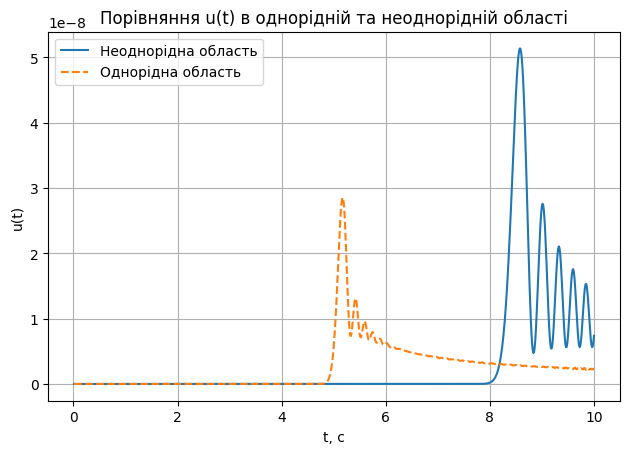

In [5]:
c_homo = np.full((Nx, Ny), 1000.0)

x, y, _, u_homo, dt, _, *_ = wave_solver_2d(Nx, Ny, Lx, Ly, T_max, c_homo,
    x_s=x_s, y_s=y_s, x_obs_list=x_obs, y_obs_list=y_obs, use_source=True)

time = np.linspace(dt, T_max, len(u_het[0]))
plt.figure()
plt.plot(time, u_het[0], label='Неоднорідна область')
plt.plot(time, u_homo[0], '--', label='Однорідна область')
plt.title("Порівняння u(t) в однорідній та неоднорідній області")
plt.xlabel("t, с")
plt.ylabel("u(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

dt = 0.025000 с, Nt = 400, CFL = 0.50
dt = 0.025000 с, Nt = 400, CFL = 0.50


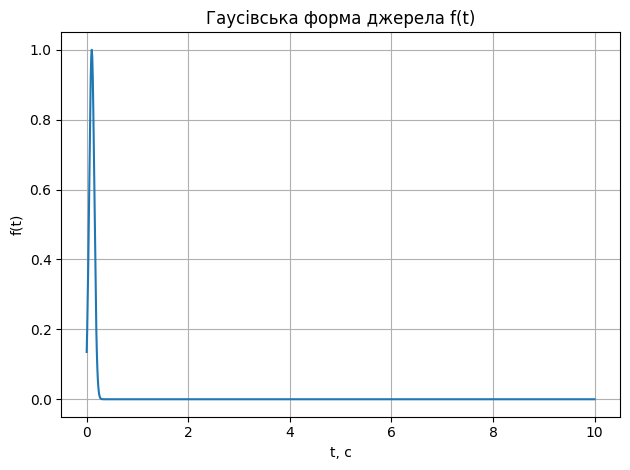

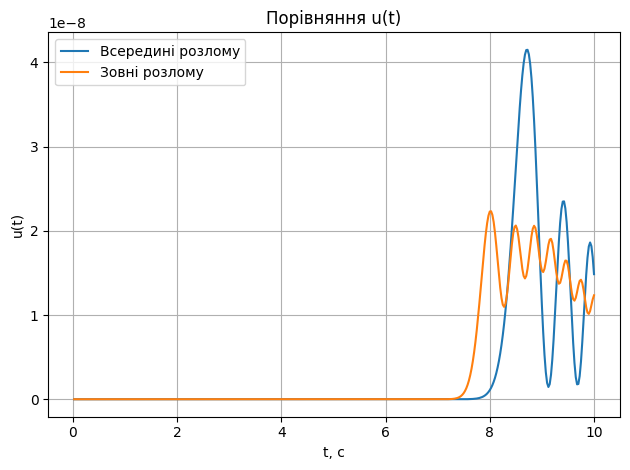

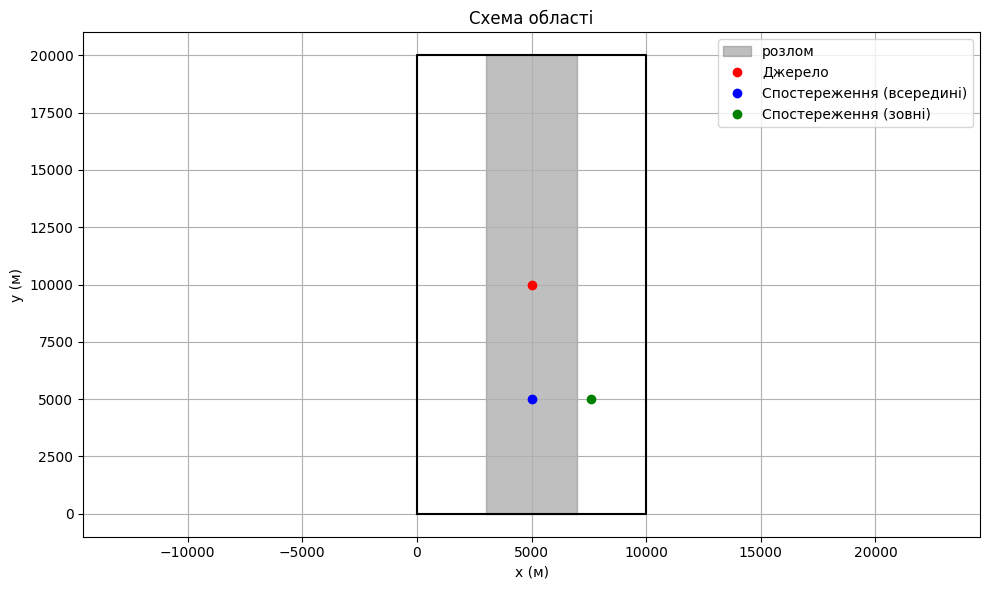

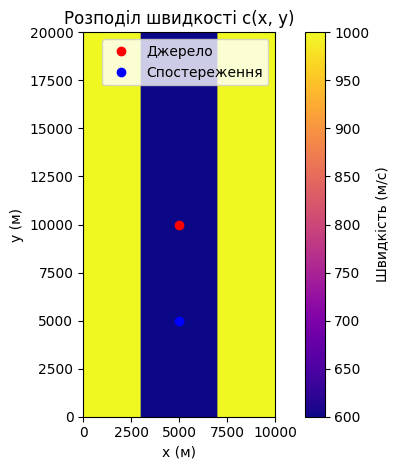

In [6]:
#ПРИКЛАД 3(ДВІ ТОЧКИ СПОСТЕРЕЖЕННЯ)
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

def source_time_function(t, t0=0.1, sigma=0.05):
    return np.exp(-((t - t0)**2) / (2 * sigma**2))

def f_source_2d(x, y, t, x_s, y_s, dx, dy):
    source = np.zeros((x.size, y.size))
    i_s = np.argmin(np.abs(x - x_s))
    j_s = np.argmin(np.abs(y - y_s))
    source[i_s, j_s] = 1.0 / (dx * dy)
    return source * source_time_function(t)

@njit
def update_wave(u, u_old, c, rhs, dx, dy, dt):
    Nx, Ny = u.shape
    u_new = np.zeros_like(u)
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            lap = ((u[i+1, j] - 2*u[i, j] + u[i-1, j]) / dx**2 +
                   (u[i, j+1] - 2*u[i, j] + u[i, j-1]) / dy**2)
            u_new[i, j] = 2 * u[i, j] - u_old[i, j] + dt**2 * (c[i, j]**2 * lap + rhs[i, j])
    return u_new

def wave_solver_2d(Nx=100, Ny=200, Lx=10000.0, Ly=20000.0, T_max=2.0,
                   c_matrix=None, x_s=None, y_s=None, x_obs_list=None, y_obs_list=None, CFL_target=0.5,
                   use_source=True):

    dx = Lx / (Nx - 1)
    dy = Ly / (Ny - 1)
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)

    if c_matrix is None:
        c = np.full((Nx, Ny), 1000.0)
    else:
        c = c_matrix

    dt = CFL_target * min(dx, dy) / np.max(c)
    Nt = int(T_max / dt)
    dt = T_max / Nt

    print(f"dt = {dt:.6f} с, Nt = {Nt}, CFL = {np.max(c) * dt / min(dx, dy):.2f}")

    u = np.zeros((Nx, Ny))
    u_old = np.zeros((Nx, Ny))

    if x_s is None: x_s = Lx / 2
    if y_s is None: y_s = Ly / 2

    if x_obs_list is None: x_obs_list = [x_s]
    if y_obs_list is None: y_obs_list = [y_s + 5000.0]

    obs_indices = [(np.argmin(np.abs(x - xo)), np.argmin(np.abs(y - yo))) for xo, yo in zip(x_obs_list, y_obs_list)]
    u_records = [[] for _ in obs_indices]

    for n in range(1, Nt + 1):
        t = n * dt
        rhs = f_source_2d(x, y, t, x_s, y_s, dx, dy) if use_source else np.zeros((Nx, Ny))
        u_new = update_wave(u, u_old, c, rhs, dx, dy, dt)
        u_new[0, :] = u_new[-1, :] = 0
        u_new[:, 0] = u_new[:, -1] = 0
        u_old[:], u[:] = u[:], u_new[:]
        for k, (i_obs, j_obs) in enumerate(obs_indices):
            u_records[k].append(u[i_obs, j_obs])

    return x, y, u, [np.array(r) for r in u_records], dt, c, x_s, y_s, x_obs_list, y_obs_list

Nx, Ny = 201, 401
Lx, Ly = 10000.0, 20000.0
T_max = 10.0

c_homo = np.full((Nx, Ny), 1000.0)

c_het = np.full((Nx, Ny), 1000.0)
ix0 = int(Nx * 0.3)
ix1 = int(Nx * 0.7)
c_het[ix0:ix1, :] = 600.0

x_s, y_s = 5000.0, 10000.0
x_obs, y_obs = [5000.0], [5000.0]

x, y, _, u_homo, dt, _, *_ = wave_solver_2d(Nx, Ny, Lx, Ly, T_max, c_homo,
    x_s=x_s, y_s=y_s, x_obs_list=x_obs, y_obs_list=y_obs, use_source=True)

x_obs = [5000.0, 7600.0]
y_obs = [5000.0, 5000.0]

x, y, _, u_het, _, c_het_result, *_ = wave_solver_2d(Nx, Ny, Lx, Ly, T_max, c_het,
    x_s=x_s, y_s=y_s, x_obs_list=x_obs, y_obs_list=y_obs, use_source=True)

t_arr = np.linspace(0, T_max, 1000)
f_arr = source_time_function(t_arr)
plt.figure()
plt.plot(t_arr, f_arr)
plt.title("Гаусівська форма джерела f(t)")
plt.xlabel("t, с")
plt.ylabel("f(t)")
plt.grid(True)
plt.tight_layout()
plt.show()

time = np.linspace(dt, T_max, len(u_het[0]))
plt.figure()
plt.plot(time, u_het[0], label='Всередині розлому')
plt.plot(time, u_het[1], label='Зовні розлому')

plt.title("Порівняння u(t)")
plt.xlabel("t, с")
plt.ylabel("u(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot([0, Lx, Lx, 0, 0], [0, 0, Ly, Ly, 0], 'k-')
plt.fill_between([Lx*0.3, Lx*0.7], 0, Ly, color='gray', alpha=0.5, label='розлом')
plt.plot(x_s, y_s, 'ro', label='Джерело')
plt.plot(x_obs[0], y_obs[0], 'bo', label='Спостереження (всередині)')
plt.plot(x_obs[1], y_obs[1], 'go', label='Спостереження (зовні)')
plt.title("Схема області")
plt.xlabel("x (м)")
plt.ylabel("y (м)")
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.imshow(c_het_result.T, origin='lower', extent=[0, Lx, 0, Ly], cmap='plasma')
plt.colorbar(label='Швидкість (м/с)')
plt.plot(x_s, y_s, 'ro', label='Джерело')
plt.plot(x_obs[0], y_obs[0], 'bo', label='Спостереження')
plt.title("Розподіл швидкості c(x, y)")
plt.xlabel("x (м)")
plt.ylabel("y (м)")
plt.legend()
plt.tight_layout()
plt.show()